# Mateusz Kuchta nr 116111
## Model XGBoost dla predykcji zajścia zdarzenia default
###### 15.08.2023

### Rozpoczęto od instalacji niezbędnych pakietów

In [3]:
# !pip install xgboost
# !pip install category_encoders

### Kolejnym krokiem jest import zastosowanych bibliotek

In [5]:
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.tree import DecisionTreeClassifier

### Wczytano zbiór danych
#### Do budowy modelu zastosowano zbiór wykorzystywany podczas zajęć z przedmiotu "Credit scoring - automatyzacja procesu biznesowego" prowadzonego w Szkole Głównej Handlowej w Warszawie, prowadzonego przez Pana dr Karola Przanowskiego, dzięki którego uprzejmości dataset może zostać użyty w pracy.
#### Zbiór zawiera 219 zmiennych, zarówno ciągłych, jak i kategorycznych. Umieszczono w nim 68499 obserwacji, gdzie każda z nich dotyczy innej aplikacji o produkt gotówkowy (product = 'css') lub ratalny (product = 'ins')

In [7]:
source_data = pd.read_sas('abt_app.sas7bdat', encoding = 'LATIN2')
data = source_data.copy()
print("Zaimportowany zbiór danych wraz z jego rozmiarem:", data.shape)
data.head(5)

Zaimportowany zbiór danych wraz z jego rozmiarem: (68499, 219)


,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,default3,default6,default9,default12,default_cross3,default_cross6,default_cross9,default_cross12,cross_app_loan_amount,cross_app_n_installments
0,0000000001,css1970020500001,css,197002,59.0,0.492428,2.442599,2047.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000060,css1970020700004,css,197002,52.0,0.447902,1.023541,4885.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000013,css1970021100003,css,197002,38.0,0.586847,8.431703,593.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000089,css1970022400005,css,197002,37.0,0.165007,2.370792,2109.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000005,css1970022600002,css,197002,46.0,0.529964,1.805054,2770.0,5000.0,24.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5000.0,24.0


### Zdefiniowano globalne parametry
#### Jako zmienną celu wybrano 'default12' - binarny wskaźnik zajścia zdarzenia, w którym klient w trakcie pierwszych 12 miesięcy od otrzymania kredytu spóźnił się ze spłatą rat sumarycznie o co najmniej 90 dni

In [9]:
target_variable = 'default12'

#### Zdefiniowano benchmarki, które powinny być przestrzegane przez finalnie wybrany model. Zmienna 'gini_benchmark' wskazuje minimalny współczynnik Gini'ego dla modelu, zarówno dla zbioru testowego, jak i treningowego, natomiast zmienna 'gini_diff_benchmark' określa maksymalną różnicę pomiędzy współczynnikami Gini'ego w zbiorze treningowym, a Gini'm na zbiorze testowym, dla jednego modelu

In [11]:
auc_benchmark = 0.89
std_dev = 0.001

### Przetwarzanie zbioru danych
#### Zdecydowano się na ograniczenie zakresu modelu do jednego produktu - kredytu gotówkowego. Spowodowane jest to różną charakterystyką danych znanych w momencie aplikacji o tzw. "gotówkę" w odniesieniu do pożyczki ratalnej. Operacja ta obniżyła liczbę obserwacji do 34188.

In [13]:
data_css = data.loc[data['product'] == 'css'].copy()
print("Rozmiar zbioru danych dla produktu 'css':", data_css.shape)

Rozmiar zbioru danych dla produktu 'css': (34188, 219)


#### Po analizie rozkładu wartości binarnej zmiennej celu stwierdzono, w zbiorze znajduje się dostatecznie dużo "default'ów" (w literaturze można znaleźć informację, że do budowy poprawnego modelu scoring'owego wymagane jest posiadanie w analizowanym zbiorze co najmniej 300 dłużników).

In [15]:
print("Rozkład wartości zmiennej celu w zbiorze danych dla produktu 'css':")
print(data_css[target_variable].value_counts())
print("Liczba braków danych zmiennej celu w zbiorze danych dla produktu 'css':",
      data_css[target_variable].isnull().sum())

Rozkład wartości zmiennej celu w zbiorze danych dla produktu 'css':
default12
1.0    19986
0.0     9791
Name: count, dtype: int64
Liczba braków danych zmiennej celu w zbiorze danych dla produktu 'css': 4411


#### Ze zbioru pozbyto się obserwacji, w których odnotowano braki danych. Jest ich dużo, jeśli chodzi o wartość bezwzględną, jednakże uwzględniając rozmiar całego zestawu danych, nie uwzględnianie tych informacji nie powinno zaszkodzić modelowi. Dodatkowo, posortowano dane względem zmiennej 'aid'.

In [17]:
data_css.dropna(subset = [target_variable], inplace = True)
data_css.sort_values(by = ['aid'], inplace = True)
print(" Rozmiar zbioru danych dla produktu 'css'\n", 
      "po wyeliminowaniu obserwacji z brakami danych w tej zmiennej:", data_css.shape)

 Rozmiar zbioru danych dla produktu 'css'
 po wyeliminowaniu obserwacji z brakami danych w tej zmiennej: (29777, 219)


### Przetwarzanie zmiennych
#### Znając logikę nazewnictwa zmiennych w zbiorze, utworzono listę nazw zmiennych dla przedrostków 'app', 'act', 'agr' oraz 'ags'

In [19]:
variables = [variable for variable in list(data_css) 
             if any(variable.casefold().startswith(prefix) for prefix in ['app', 'act', 'agr', 'ags'])]
print('Liczba zmiennych spełniających warunek określonego przedrostka =', len(variables))

Liczba zmiennych spełniających warunek określonego przedrostka = 201


#### Konieczne jest rozdzielenie zmiennych ze względu na ich zawartość - na zmienne jakościowe(char) oraz ilościowe(num)

In [21]:
variables_char_list = list(data_css[variables].select_dtypes(include = 'object'))
variables_num_list = list(data_css[variables].select_dtypes(include = 'number'))
print('Liczba zmiennych jakościowych =', len(variables_char_list))
print('Liczba zmiennych ilościowych =', len(variables_num_list))

Liczba zmiennych jakościowych = 7
Liczba zmiennych ilościowych = 194


#### Model XGBoost nie jest w stanie operować na zmiennych jakościowych, co wymusza konieczność zastosowania kodowania\kategoryzacji tychże zmiennych. W tym celu skorzystano z pakietu category_encoders mającego możliwość kodowania binarnego. 7 zmiennych jakościowych zostało poddane temu procesowi, na skutek czego powstało 16 nowych zmiennych binarnych.

In [23]:
encoding = ce.BinaryEncoder(cols = variables_char_list)
data_encoded = encoding.fit_transform(data_css[variables_char_list])
variables_char_encoded_list = list(data_encoded)
print("Lista", len(variables_char_encoded_list),"zbinowanych zmiennych jakościowych:")
variables_char_encoded_list

Lista 16 zbinowanych zmiennych jakościowych:


['app_char_branch_0',
 'app_char_gender_0',
 'app_char_gender_1',
 'app_char_job_code_0',
 'app_char_job_code_1',
 'app_char_job_code_2',
 'app_char_marital_status_0',
 'app_char_marital_status_1',
 'app_char_marital_status_2',
 'app_char_city_0',
 'app_char_city_1',
 'app_char_city_2',
 'app_char_home_status_0',
 'app_char_home_status_1',
 'app_char_cars_0',
 'app_char_cars_1']

#### Nowo powstałe zmienne dołączono do zbioru pełnego dla produktu 'css', tworząc nowy zbiór 'data_full'

In [25]:
data_full = pd.concat([data_css, data_encoded], axis = 1, join = 'inner')
print("Nowy zbiór danych, powstały z połączenia zbioru oryginalnego dla produktu gotówkowego")
print("oraz zbioru składającego się z nowo utworzonych zmiennych binarnych:")
data_full

Nowy zbiór danych, powstały z połączenia zbioru oryginalnego dla produktu gotówkowego
oraz zbioru składającego się z nowo utworzonych zmiennych binarnych:


,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,app_char_marital_status_0,app_char_marital_status_1,app_char_marital_status_2,app_char_city_0,app_char_city_1,app_char_city_2,app_char_home_status_0,app_char_home_status_1,app_char_cars_0,app_char_cars_1
0,0000000001,css1970020500001,css,197002,59.0,0.492428,2.442599,2047.0,5000.0,24.0,...,0,0,1,0,0,1,0,1,0,1
1,0000000060,css1970020700004,css,197002,52.0,0.447902,1.023541,4885.0,5000.0,24.0,...,0,0,1,0,1,0,1,0,0,1
2,0000000013,css1970021100003,css,197002,38.0,0.586847,8.431703,593.0,5000.0,24.0,...,0,0,1,0,1,1,0,1,0,1
3,0000000089,css1970022400005,css,197002,37.0,0.165007,2.370792,2109.0,5000.0,24.0,...,0,0,1,0,1,0,0,1,0,1
4,0000000005,css1970022600002,css,197002,46.0,0.529964,1.805054,2770.0,5000.0,24.0,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34183,0000009715,css1988122500162,css,198812,86.0,0.234753,2.876870,1738.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,1,0
34184,0000017452,css1988122500175,css,198812,72.0,0.729145,5.149331,971.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,0,1
34185,0000000040,css1988122600002,css,198812,84.0,0.405874,3.337784,1498.0,5000.0,24.0,...,0,1,0,0,0,1,0,1,1,0
34186,0000000081,css1988122600006,css,198812,93.0,0.624339,4.409171,1134.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,0,1


#### Utworzono dwie listy zmiennych - pierwsza, zawierająca jedynie zmienne numeryczne oraz zmienne jakościowe binowane; druga, składająca się dodatkowo ze zmiennej celu, zmiennej czasowej oraz identyfikatora

In [27]:
variables_full_wo_target = variables_num_list + variables_char_encoded_list
variables_full = variables_num_list + variables_char_encoded_list + [target_variable] + ['period'] + ['aid']
print("Liczba zmiennych używanych do budowy modelu:", len(variables_full))

Liczba zmiennych używanych do budowy modelu: 213


### Budowa modelu XGBoost

#### Pierwszy zbudowany model, stanowił element poglądowy do dalszej analizy. Jego głównym celem, było zbudowanie prostego modelu XGBoost na przygotowanych danych, celem zgrubnego oszacowania istotności zmiennych przy pomocy wskaźnika Feature Importance

Średni wynik AUC: 0.90
Odchylenie standardowe wyników AUC: 0.00


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

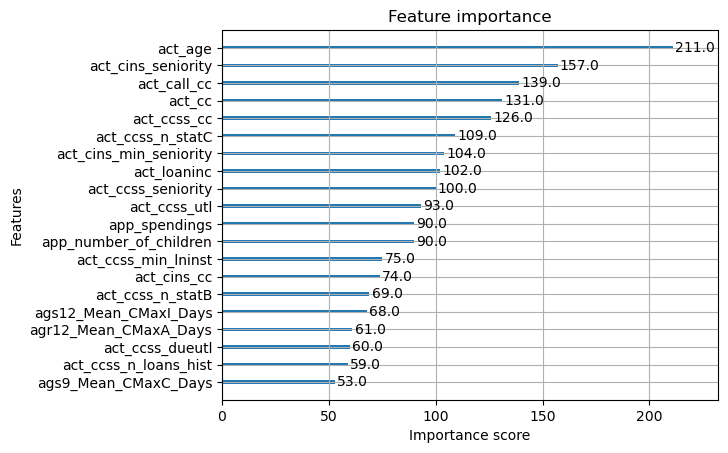

In [30]:
X = data_full[variables_full_wo_target]
y = data_full[target_variable]

# Definicja modelu XGBoost
model = xgb.XGBClassifier(
    max_depth=6,
    seed=1998,
    objective='binary:logitraw',
    learning_rate=0.3,
    min_split_loss=0,
    eval_metric='auc'
)

# Przygotowanie obiektu do cross-walidacji K-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Przeprowadzenie cross-walidacji
results = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')

# Obliczenie średniej i odchylenia standardowego wyników
mean_auc = np.mean(results)
std_auc = np.std(results)

print(f'Średni wynik AUC: {mean_auc:.2f}')
print(f'Odchylenie standardowe wyników AUC: {std_auc:.2f}')

# Możesz również wyświetlić wynik AUC dla każdej iteracji cross-walidacji, jeśli jest to potrzebne
#for i, auc in enumerate(results):
#    print(f'AUC dla foldu {i+1}: {auc:.2f}')

# Ostatecznie, możesz wykorzystać model M_premodel po treningu na całym zbiorze treningowym
model.fit(X, y)

# Wykres ważności cech
xgb.plot_importance(model, max_num_features = 20)

### Analiza eksploracyjna zmiennych
#### Przeanalizowano 3 z 5 najważniejszych zmiennych, opierając się na wskazaniach statystyki Feature Importance wygenerowanej na podstawie modelu wstępnego
#### Na wstępie stworzono dwa podzbiory, podzielone ze względu na wartość zmiennej celu

In [32]:
data0 = data_full.loc[data_full['default12'] == 0].copy()
data1 = data_full.loc[data_full['default12'] == 1].copy()

#### Jako pierwszą przeanalizowano zmienną act_age, oznaczającej wiek klienta w momencie składania wniosku kredytowego

In [34]:
print(data0['act_age'].describe())
print("Liczba braków danych w zmiennej 'act_age' w zbiorze 'data0' jest równa:", 
      data0['act_age'].isnull().sum())

count    9791.000000
mean       63.028904
std        11.340882
min        30.000000
25%        55.000000
50%        63.000000
75%        71.000000
max        93.000000
Name: act_age, dtype: float64
Liczba braków danych w zmiennej 'act_age' w zbiorze 'data0' jest równa: 0


In [35]:
alpha = 0.05  # Poziom istotności
contingency_table = pd.crosstab(data_full['act_age'], data_full['default12'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Wartość statystyki Chi-kwadrat dla zmiennej act_age:", chi2)
print("Wartość p-value:", p)
if p < alpha:
    print("Zmienna 'act_age' jest istotna względem zmiennej 'default12'")
else:
    print("Zmienna 'act_age' nie jest istotna względem zmiennej 'default12'")

Wartość statystyki Chi-kwadrat dla zmiennej act_age: 186.85737675770173
Wartość p-value: 4.978645314537384e-13
Zmienna 'act_age' jest istotna względem zmiennej 'default12'


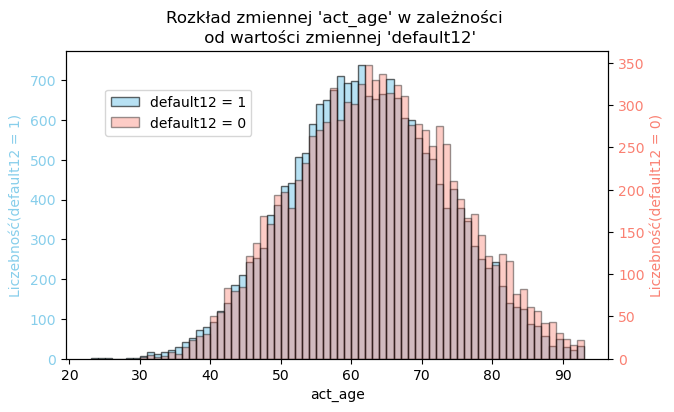

In [36]:
fig, wyk1 = plt.subplots(figsize=(7, 4))

wyk1.hist(data1['act_age'], bins = 70, alpha = 0.6, label = 'default12 = 1', 
          color = 'skyblue', edgecolor = 'black')
wyk1.set_xlabel('act_age')
wyk1.set_ylabel('Liczebność(default12 = 1)', color = 'skyblue')
wyk1.tick_params(axis = 'y', labelcolor = 'skyblue')

wyk2 = wyk1.twinx()
wyk2.hist(data0['act_age'], bins = 63, alpha = 0.4, label = 'default12 = 0', 
          color = 'salmon', edgecolor = 'black')
wyk2.set_ylabel('Liczebność(default12 = 0)', color = 'salmon')
wyk2.tick_params(axis = 'y', labelcolor = 'salmon')

plt.title("Rozkład zmiennej 'act_age' w zależności \n od wartości zmiennej 'default12'")
fig.legend(loc='upper right', bbox_to_anchor=(0.4, 0.8))
plt.show()

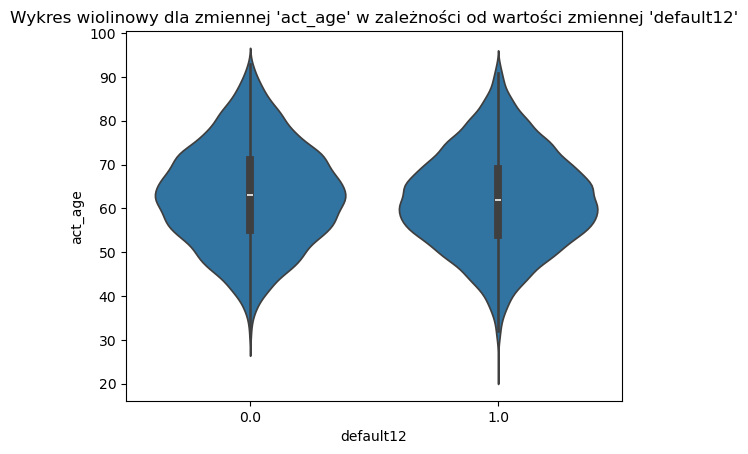

In [37]:
sns.violinplot(x='default12', y='act_age', data=data_full)
plt.title("Wykres wiolinowy dla zmiennej 'act_age' w zależności od wartości zmiennej 'default12'")
plt.show()

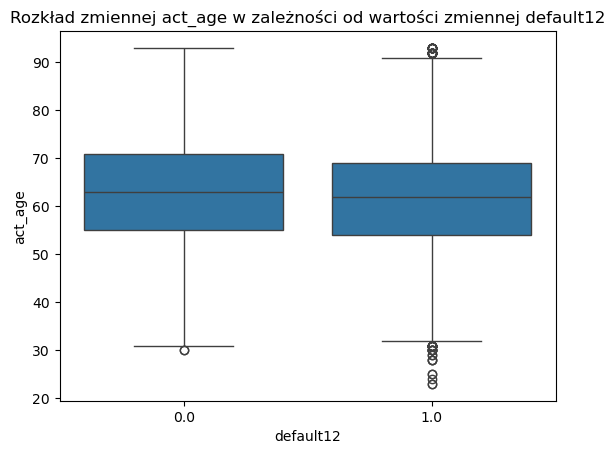

In [38]:
sns.boxplot(x='default12', y='act_age', data=data_full)
plt.title("Rozkład zmiennej act_age w zależności od wartości zmiennej default12")
plt.show()

#### Jako drugą przeanalizowano zmienną act_call_cc, oznaczającą sumę potencjalnych rat kredytu i wydatków w stosunku do dochodów klienta

In [40]:
print(data0['act_call_cc'].describe())
print("Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data0' jest równa:", 
      data0['act_call_cc'].isnull().sum())

count    9791.000000
mean        0.925345
std         0.436998
min         0.099325
25%         0.628913
50%         0.851278
75%         1.126885
max         4.622150
Name: act_call_cc, dtype: float64
Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data0' jest równa: 0


In [41]:
print(data1['act_call_cc'].describe())
print("Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data1' jest równa:", 
      data1['act_call_cc'].isnull().sum())

count    19986.000000
mean         1.141037
std          0.590710
min          0.075747
25%          0.721041
50%          1.010427
75%          1.423545
max          6.964356
Name: act_call_cc, dtype: float64
Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data1' jest równa: 0


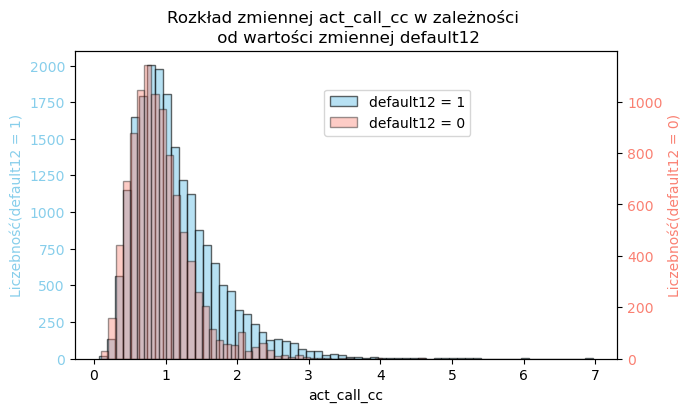

In [42]:
fig, wyk1 = plt.subplots(figsize=(7, 4))

wyk1.hist(data1['act_call_cc'], bins = 62, alpha = 0.6, label = 'default12 = 1', 
          color = 'skyblue', edgecolor = 'black')
wyk1.set_xlabel('act_call_cc')
wyk1.set_ylabel('Liczebność(default12 = 1)', color = 'skyblue')
wyk1.tick_params(axis = 'y', labelcolor = 'skyblue')

wyk2 = wyk1.twinx()
wyk2.hist(data0['act_call_cc'], bins = 45, alpha = 0.4, label = 'default12 = 0', 
          color = 'salmon', edgecolor = 'black')
wyk2.set_ylabel('Liczebność(default12 = 0)', color = 'salmon')
wyk2.tick_params(axis = 'y', labelcolor = 'salmon')

plt.title('Rozkład zmiennej act_call_cc w zależności \n od wartości zmiennej default12')
fig.legend(loc='upper right', bbox_to_anchor=(0.7, 0.8))
plt.show()

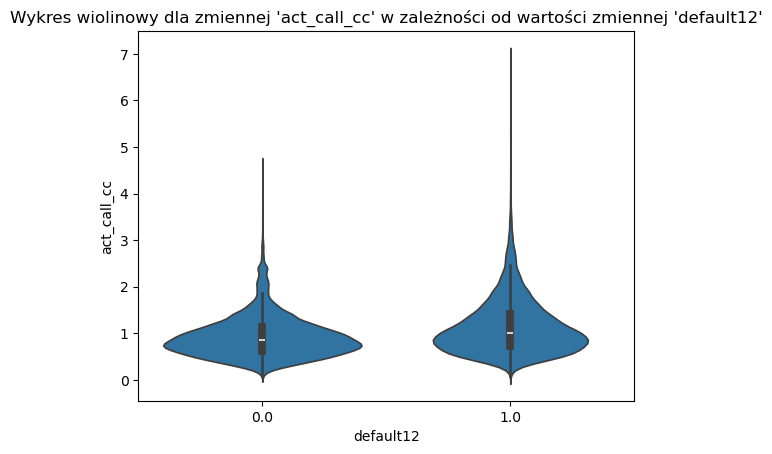

In [43]:
sns.violinplot(x='default12', y='act_call_cc', data=data_full)
plt.title("Wykres wiolinowy dla zmiennej 'act_call_cc' w zależności od wartości zmiennej 'default12'")
plt.show()

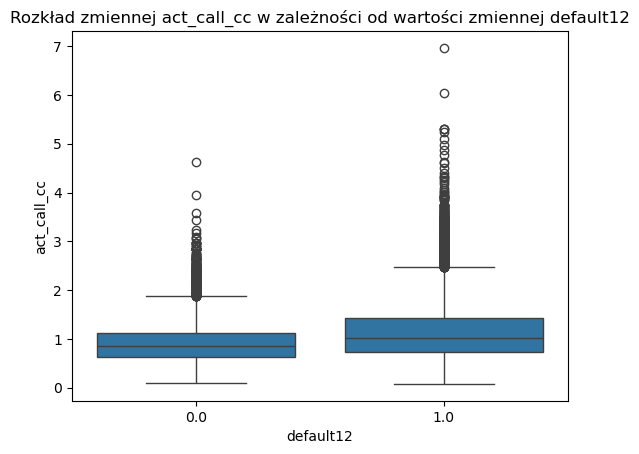

In [44]:
sns.boxplot(x='default12', y='act_call_cc', data=data_full)
plt.title("Rozkład zmiennej act_call_cc w zależności od wartości zmiennej default12")
plt.show()

#### Następnie zbadano zmienną act_ccss_n_statC, oznaczającej liczbę poprawnie w pełni spłaconych zobowiązań klienta w momencie składania wniosku kredytowego

In [46]:
print(data0['act_ccss_n_statC'].describe())
print("Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data0' jest równa:", 
      data0['act_ccss_n_statC'].isnull().sum())

count    7889.000000
mean        6.196096
std        10.407138
min         0.000000
25%         0.000000
50%         1.000000
75%         7.000000
max        48.000000
Name: act_ccss_n_statC, dtype: float64
Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data0' jest równa: 1902


In [47]:
print(data1['act_ccss_n_statC'].describe())
print("Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data1' jest równa:", 
      data1['act_ccss_n_statC'].isnull().sum())

count    18894.000000
mean         2.110194
std          3.654164
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         43.000000
Name: act_ccss_n_statC, dtype: float64
Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data1' jest równa: 1092


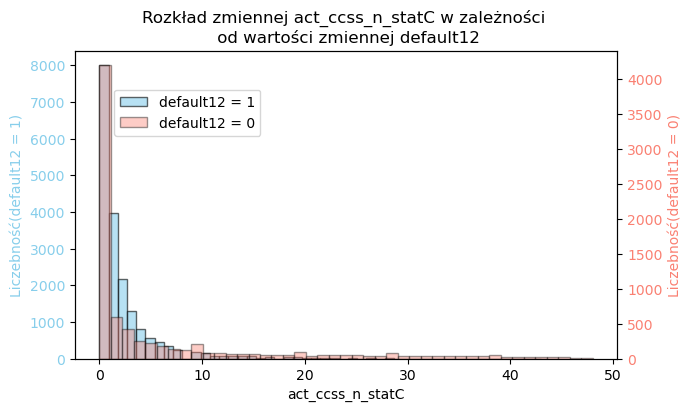

In [48]:
fig, wyk1 = plt.subplots(figsize=(7, 4))

wyk1.hist(data1['act_ccss_n_statC'], bins = 48, alpha = 0.6, label = 'default12 = 1', 
          color = 'skyblue', edgecolor = 'black')
wyk1.set_xlabel('act_ccss_n_statC')
wyk1.set_ylabel('Liczebność(default12 = 1)', color = 'skyblue')
wyk1.tick_params(axis = 'y', labelcolor = 'skyblue')

wyk2 = wyk1.twinx()
wyk2.hist(data0['act_ccss_n_statC'], bins = 43, alpha = 0.4, label = 'default12 = 0', 
          color = 'salmon', edgecolor = 'black')
wyk2.set_ylabel('Liczebność(default12 = 0)', color = 'salmon')
wyk2.tick_params(axis = 'y', labelcolor = 'salmon')

plt.title('Rozkład zmiennej act_ccss_n_statC w zależności \n od wartości zmiennej default12')
fig.legend(loc='upper right', bbox_to_anchor=(0.4, 0.8))
plt.show()

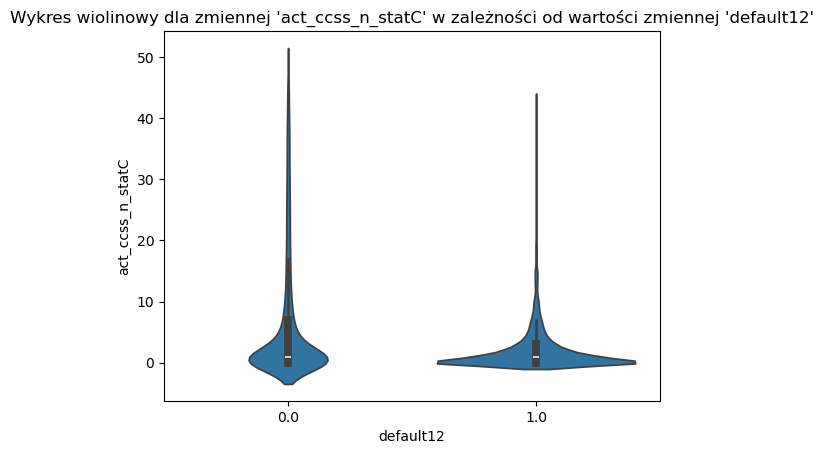

In [49]:
sns.violinplot(x='default12', y='act_ccss_n_statC', data=data_full)
plt.title("Wykres wiolinowy dla zmiennej 'act_ccss_n_statC' w zależności od wartości zmiennej 'default12'")
plt.show()

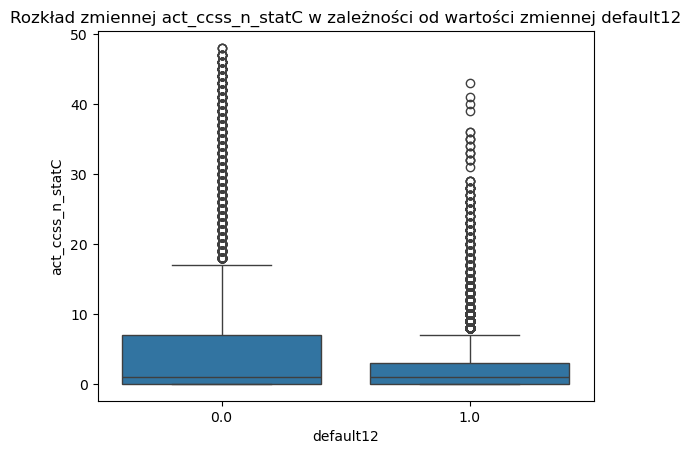

In [50]:
sns.boxplot(x='default12', y='act_ccss_n_statC', data=data_full)
plt.title("Rozkład zmiennej act_ccss_n_statC w zależności od wartości zmiennej default12")
plt.show()

#### Po przeanalizowaniu ważności zmiennych, dokonano iteracyjnego, wielokrotnego trenowania modeli z różnymi parametrami dostępnymi w pakiecie xgboost. Następnie przeprowadzono analizę średnich współczynników Giniego oraz odchylenia standardowe w procesie cross-walidacji dla poszczególnych modeli. 

In [52]:
X = data_full[variables_full_wo_target]
y = data_full[target_variable]

df = pd.DataFrame( 
                    {
                        'AUC' : [],
                        'max_depth' : [],
                        'learning_rate' : [],
                        'min_split_loss' : [],
                        'std_dev' : []
                    }
                 )

for i in range(3):
    for j in range(5):
        for k in range(5):
            M = xgb.XGBClassifier(  
                                max_depth = i+3, 
                                seed = 1998, 
                                objective = 'binary:logitraw',
                                learning_rate = 0.1 * (j + 5),
                                min_split_loss = k + 3, 
                                eval_metric = 'auc'
                        )


            # Przygotowanie obiektu do kroswalidacji K-fold
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            # Przeprowadzenie cross-walidacji
            results = cross_val_score(M, X, y, cv=kfold, scoring='roc_auc')
            # Obliczenie średniej i odchylenia standardowego wyników
            mean_auc = np.mean(results)
            std_auc = np.std(results)

            df.loc[len(df)] =   {
                                    'AUC': mean_auc, 
                                    'max_depth': i + 3, 
                                    'learning_rate': 0.1 * (j + 5),
                                    'min_split_loss' : k + 3,
                                    'std_dev': std_auc
                                }
df

,AUC,max_depth,learning_rate,min_split_loss,std_dev
0,0.908304,3,0.5,3,0.001606
1,0.907940,3,0.5,4,0.001666
2,0.907534,3,0.5,5,0.001729
3,0.906658,3,0.5,6,0.001698
4,0.906233,3,0.5,7,0.001652
...,...,...,...,...,...
70,0.885890,5,0.9,3,0.003809
71,0.889718,5,0.9,4,0.002057
72,0.892367,5,0.9,5,0.002460
73,0.893796,5,0.9,6,0.002099


#### Najlepszy model wybrano dobierając odpowiednie benchmarki

In [54]:
df_filtered = df.loc[(df['AUC'] > auc_benchmark) & 
                     (df['std_dev'] < std_dev)].copy()
df_filtered.sort_values(by = ['AUC'], ascending = False, inplace = True)
df_filtered.head(1)
#df_filtered

,AUC,max_depth,learning_rate,min_split_loss,std_dev
26,0.905969,4,0.5,4,0.000187


#### Po wybraniu optymalnych parametrów modelu, zapisano go pod zmienną M_chosen_model

In [56]:
from sklearn.metrics import roc_curve, auc as sklearn_auc

X = data_full[variables_full_wo_target]
Y = data_full[target_variable]

M_chosen_model = xgb.XGBClassifier(  
                                max_depth = 3, 
                                seed = 1998, 
                                objective = 'binary:logitraw',
                                learning_rate = 0.5,
                                min_split_loss = 3, 
                                eval_metric = 'auc'
                                )

# Przygotowanie obiektu do cross-walidacji K-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Przeprowadzenie cross-walidacji i zbieranie wyników AUC
roc_aucs = []
for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    M_chosen_model.fit(X_train, y_train)
    y_prob = M_chosen_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc_value = sklearn_auc(fpr, tpr)  
    
    roc_aucs.append(roc_auc_value)

# Obliczenie średniej i odchylenia standardowego wyników AUC
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)

# Wyświetlenie wyników AUC
print('Mean AUC = ', '{:.2%}'.format(mean_auc))
print('Std Dev AUC = ', '{:.2}'.format(std_auc))

Mean AUC =  90.83%
Std Dev AUC =  0.0016


### Wizualizacje
#### Zwizualizowano skuteczność modelu, przy pomocy krzywej ROC, celem sprawdzenia jej kształtu
#### Dodatkowo, ponownie zweryfikowano ważność poszczególnych zmiennych, tym razem w finalnym modelu, celem porównania z modelem wstępnym

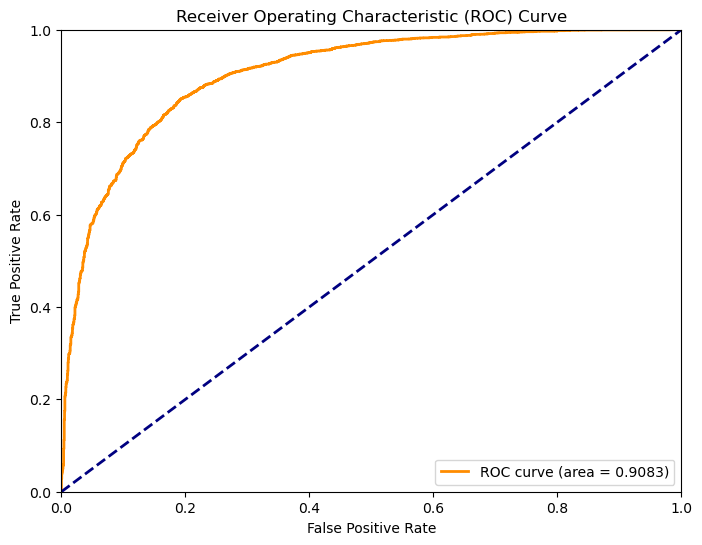

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

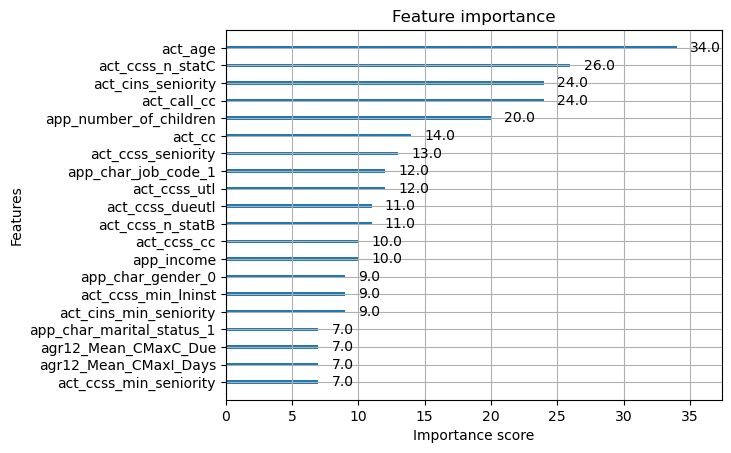

In [58]:
# Wyrysowanie krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
xgb.plot_importance(M_chosen_model, max_num_features = 20)

### Postprocessing
#### Zapisano model do zewnętrznego pliku

In [60]:
M_chosen_model.save_model('XGBoostModel_MK116111_2.model')

C:\Users\kucht\anaconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:56:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


### Adversarial Machine Learning
#### TEST 1 - zmiana wartości zmiennej celu dla pewnego % danych treningowych
#### W ramach tego testu, wybrano w zbiorze treningowym pewną część znajdujących się w nim obserwacji i zmieniono wartość zmiennej celu 'default12' na wartość odwrotną
#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [62]:
data_AML1 = data_full
print("Rozmiar zbioru:", data_AML1.shape)

Rozmiar zbioru: (29777, 235)


#### Wybrano zakres wartości procentowej zmienianych danych jako zmienną 'attacked_proc1', co dla "'attacked_proc1' = 15" oznacza, że wykonano 15 testów, gdzie kolejne wartości procentowe zmienionych danych znajdowały się w zakresie liczb całkowitych od 1 do 15

In [64]:
attacked_proc1 = 15

#### Zdefniowano ramkę danych 'df_AML1', w której były umieszczane statystyki dla kolejnych testów.
#### Następnie w pętli for dokonywano losowania liczby manipulowanych obserwacji, obliczając ją na podstawie zdefiniowanej wcześniej wartości 'attacked_proc1'. Dla wylosowanej próby dokonywano podmianę wartości zmiennej 'default12' bezpośrednio w zbiorze danych.
#### W kolejnym kroku dokonano standardowych operacji przygotowania zmanipulowanego zbioru do wykonania na nim procesu przetrenowania modelu, stosując parametry identyczne jak w modelu finalnym.
#### Po wykonaniu cross-walidacji, statystyki współczynnika AUC umieszczono w przygotowanej wcześniej ramce danych 'df_AML1'

In [66]:
df_AML1 = pd.DataFrame( 
                    {
                        'AUC' : [],
                        'std_dev' : [],
                        '% atakowanych danych' : [],
                    }
                 )
M_chosen_model = xgb.XGBClassifier(  
                                max_depth = 3, 
                                seed = 1998, 
                                objective = 'binary:logitraw',
                                learning_rate = 0.5,
                                min_split_loss = 3, 
                                eval_metric = 'auc'
                                )

for x in range(attacked_proc1 + 1):
    nofRows = math.ceil(x * len(data_AML1.index) / 100)
    data_AML1_attacked = data_AML1.copy()
    attacked_sample1 = data_AML1.sample(n = nofRows, 
                                        random_state = 1234, 
                                        replace = False)

    for j in attacked_sample1.index:
        if data_AML1.loc[j, 'default12'] == 0:
            data_AML1_attacked.loc[j, 'default12'] = 1
        else: data_AML1_attacked.loc[j, 'default12'] = 0
            
    X_AML1 = data_AML1_attacked[variables_full_wo_target]
    Y_AML1 = data_AML1_attacked[target_variable]

    # Przygotowanie obiektu do cross-walidacji K-fold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    # Przeprowadzenie cross-walidacji
    results = cross_val_score(M_chosen_model, X_AML1, Y_AML1, cv=kfold, scoring='roc_auc')
    # Obliczenie średniej i odchylenia standardowego wyników
    mean_auc = np.mean(results)
    std_auc = np.std(results)
    
    df_AML1.loc[len(df_AML1)] =   {
                'AUC': '{:.4}'.format(mean_auc), 
                'std_dev': '{:.2}'.format(std_auc),
                '% atakowanych danych': '{:.0%}'.format(x/100)
                                }
df_AML1

,AUC,std_dev,% atakowanych danych
0,0.9083,0.0016,0%
1,0.8971,0.0018,1%
2,0.8864,0.0032,2%
3,0.8756,0.0027,3%
4,0.8642,0.003,4%
5,0.8537,0.0028,5%
6,0.8448,0.004,6%
7,0.8328,0.0033,7%
8,0.8237,0.0032,8%
9,0.815,0.0011,9%


#### Wyniki badań przedstawiono na wykresie liniowym

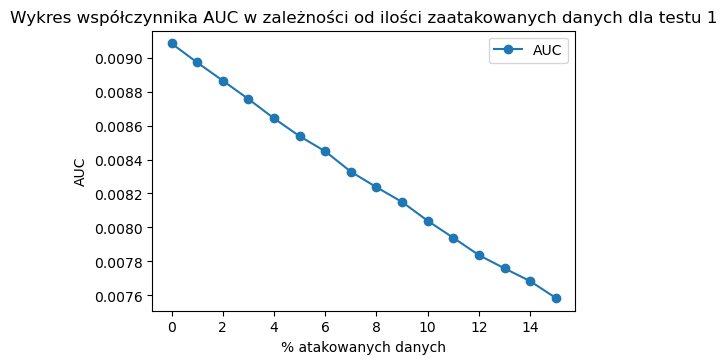

In [68]:
df_AML1_chart = df_AML1.copy()

df_AML1_chart['AUC'] = df_AML1_chart['AUC'].str.rstrip('%').astype('float') / 100
df_AML1_chart['std_dev'] = df_AML1_chart['std_dev'].str.rstrip('%').astype('float') / 100
df_AML1_chart['% atakowanych danych'] = df_AML1_chart['% atakowanych danych'
                                                                  ].str.rstrip('%').astype('int')

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(df_AML1_chart['% atakowanych danych'], df_AML1_chart['AUC'], marker='o', label='AUC')
plt.xlabel('% atakowanych danych')
plt.ylabel('AUC')
plt.title('Wykres współczynnika AUC w zależności od ilości zaatakowanych danych dla testu 1')
plt.legend()

plt.show()

#### TEST 2 - wprowadzenie pewnego % skopiowanych danych ze zbioru, do zbioru z odwróconymi wartościami.
#### W ramach tego testu, wybrano ze zbioru pewną część znajdujących się w nim obserwacji i zmieniono wartość zmiennej celu 'default12' na wartość odwrotną.
#### Następnie dodano te obserwacje do zbioru, co spowodowało obecność w tymże zbiorze par nierozróżnialnych obserwacji, różniących się wartością zmiennej celu
#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [70]:
data_AML2 = data_full
print("Rozmiar zbioru:", data_AML2.shape)

Rozmiar zbioru: (29777, 235)


#### Wybrano zakres wartości procentowej zmienianych danych jako zmienną 'attacked_proc2', gdzie "'attacked_proc2' = 15" oznacza, że wykonano 15 testów, gdzie kolejne wartości procentowe zmienionych danych znajdowały się w zakresie liczb całkowitych od 1 do 15

In [72]:
attacked_proc2 = 15

#### Zdefniowano ramkę danych 'df_AML2', w której były umieszczane statystyki dla kolejnych testów.
#### Następnie w pętli for dokonywano losowania liczby manipulowanych obserwacji, obliczając ją na podstawie zdefiniowanej wcześniej wartości 'attacked_proc2'. Dla wylosowanej próby dokonywano podmianę wartości zmiennej 'default12' i dodawano ją do zbioru.
#### W kolejnym kroku dokonano standardowych operacji przygotowania zmanipulowanego zbioru do wykonania na nim procesu przetrenowania modelu, stosując parametry identyczne jak w modelu finalnym.
#### Po zweryfikowaniu przetrenowanych modeli, statystyki współczynnika AUC umieszczono w przygotowanej wcześniej ramce danych 'df_AML2'

In [ ]:
df_AML2 = pd.DataFrame( 
                    {
                        'AUC' : [],
                        'std_dev' : [],
                        '% atakowanych danych' : [],
                    }
                 )

M_chosen_model = xgb.XGBClassifier(  
                                max_depth = 3, 
                                seed = 1998, 
                                objective = 'binary:logitraw',
                                learning_rate = 0.5,
                                min_split_loss = 3, 
                                eval_metric = 'auc'
                                )

for x in range(attacked_proc2 + 1):
    nofRows = math.ceil(x * len(data_AML2.index) / 100)
    data_AML2_attacked = data_AML2.drop(data_AML2.index)
    attacked_sample2 = data_AML2.sample(n = nofRows, random_state = 5678, replace = False)
    attacked_sample2.reset_index(drop=True, inplace=True)

    for j in range(len(attacked_sample2.index)):
        if attacked_sample2.loc[j, 'default12'] == 0:
            attacked_sample2.loc[j, 'default12'] = 1
        else: 
            attacked_sample2.loc[j, 'default12'] = 0
    
    data_AML2_attacked = pd.concat([data_AML2, attacked_sample2])
    
    X_AML2 = data_AML2_attacked[variables_full_wo_target]
    Y_AML2 = data_AML2_attacked[target_variable]

    # Przygotowanie obiektu do cross-walidacji K-fold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    # Przeprowadzenie cross-walidacji
    results = cross_val_score(M_chosen_model, X_AML2, Y_AML2, cv=kfold, scoring='roc_auc')
    # Obliczenie średniej i odchylenia standardowego wyników
    mean_auc = np.mean(results)
    std_auc = np.std(results)
    
    df_AML2.loc[len(df_AML2)] =   {
                'AUC': '{:.4}'.format(mean_auc), 
                'std_dev': '{:.2}'.format(std_auc),
                '% atakowanych danych': '{:.0%}'.format(x/100)
                                    }
df_AML2

#### Wyniki badań przedstawiono na wykresie liniowym

In [ ]:
df_AML2_chart = df_AML2.copy()

df_AML2_chart['AUC'] = df_AML2_chart['AUC'].str.rstrip('%').astype('float') / 100
df_AML2_chart['std_dev'] = df_AML2_chart['std_dev'].str.rstrip('%').astype('float') / 100
df_AML2_chart['% atakowanych danych'] = df_AML2_chart['% atakowanych danych'
                                                                  ].str.rstrip('%').astype('int')

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(df_AML2_chart['% atakowanych danych'], df_AML2_chart['AUC'], marker='o', label='AUC')
plt.xlabel('% atakowanych danych')
plt.ylabel('AUC')
plt.title('Wykres współczynnika AUC w zależności od ilości zaatakowanych danych dla testu 2')
plt.legend()

plt.show()

#### TEST 3 - manipulacja konkretną obserwacją/wnioskiem celem zmiany klasyfikacji modelu - atak na trzy zmienne jednocześnie

#### Atak na zmienne 'act_age', 'act_call_cc' oraz 'act_cins_seniority'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [ ]:
data_AML3 = data_full
print("Rozmiar zbioru:", data_AML3.shape)

#### Następnie wylosowano ze zbioru obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [ ]:
data_AML3_zeros = data_AML3.query("default12 == 1").sample(n = 118, random_state = 3456, replace = False)
data_AML3_zeros.reset_index(drop=True, inplace=True)

In [ ]:
X = data_full[variables_full_wo_target]
Y = data_full[target_variable]
M_chosen_model.fit(X, Y)

X_preAML3 = data_AML3_zeros[variables_full_wo_target]

Y_M_train_chosen_model_preAML3 = M_chosen_model.predict(np.array(X_preAML3))

pre_rounded_predictions = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_preAML3]

pre_true_labels = data_AML3_zeros['default12']
accuracy = accuracy_score(pre_true_labels, pre_rounded_predictions)
print(f"Dokładność przewidywań: {accuracy:.2f}")

In [ ]:
data_AML3_zeros.insert(0, "preModelResponse", pre_rounded_predictions, True)
data_AML3_zeros = data_AML3_zeros.query("default12 == preModelResponse")
data_AML3_zeros.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {data_AML3_zeros.shape[0]}") 

#### Dopuszczono na modyfikację atakowanych zmiennych do 5 % ich wartości zarówno w górę, jak i w dół - w przypadku zmiennej 'act_age', która ma wartości całkowite, zdecydowano się na modyfikację jej wartości od 1 do 5. 

In [ ]:
data_AML3_attacked = data_AML3_zeros.drop(data_AML3_zeros.index)

for ind in range(len(data_AML3_zeros.index)):
    row = data_AML3_zeros[data_AML3_zeros.index == ind].copy()
    count = 5
    var_name = 'act_age'
    cons1 = 1
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        data_AML3_attacked = pd.concat([data_AML3_attacked, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        data_AML3_attacked = pd.concat([data_AML3_attacked, plus])
        
AML3_var1 = data_AML3_attacked
#train_AML3_var1

In [ ]:
data_AML3_attacked = data_AML3_zeros.drop(data_AML3_zeros.index)

for ind in range(len(AML3_var1.index)):
    row = AML3_var1[AML3_var1.index == ind].copy()
    count = 5
    var_name = 'act_call_cc'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        data_AML3_attacked = pd.concat([data_AML3_attacked, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        data_AML3_attacked = pd.concat([data_AML3_attacked, plus])

AML3_var2 = data_AML3_attacked
#train_AML3_var2

In [ ]:
data_AML3_attacked = data_AML3_zeros.drop(data_AML3_zeros.index)

for ind in range(len(AML3_var2.index)):
    row = AML3_var2[AML3_var2.index == ind].copy()
    count = 5
    var_name = 'act_cins_seniority'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        data_AML3_attacked = pd.concat([data_AML3_attacked, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        data_AML3_attacked = pd.concat([data_AML3_attacked, plus])

data_AML3_attacked.reset_index(drop=True, inplace=True)
#data_AML3_attacked

#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [ ]:
X_AML3 = data_AML3_attacked[variables_full_wo_target]

Y_M_chosen_model_AML3 = M_chosen_model.predict(np.array(X_AML3))

rounded_predictions = [1 if pred >= 0.5 else 0 for pred in Y_M_chosen_model_AML3]

true_labels = data_AML3_attacked['default12']
accuracy = accuracy_score(true_labels, rounded_predictions)
print(f"Dokładność przewidywań: {accuracy:.4f}")

In [ ]:
data_AML3_attacked.insert(0, "modelResponse", rounded_predictions, True)
#data_AML3_attacked[['act_age', 'act_call_cc', 'act_cins_seniority', 'modelResponse']].query("modelResponse == 0")

In [ ]:
print("Liczba obserwacji ze zmienioną klasyfikacją:", data_AML3_attacked.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", data_AML3_attacked.shape[0])

In [ ]:
# Dane tabelaryczne
odchylenia = [1, 2, 3, 4, 5]
skutecznosc = [1.0000, 0.9975, 0.9950, 0.9925, 0.9899]

# Tworzenie wykresu liniowego
plt.figure(figsize=(10, 6))
plt.plot(odchylenia, skutecznosc, marker='o', linestyle='-', color='b')
plt.title('Skuteczność modelu w zależności od % odchylenia')
plt.xlabel('% Odchylenia')
plt.ylabel('Skuteczność modelu')
plt.grid(True)

# Dostosowanie zakresów na osiach X i Y oraz skali wykresu
plt.xlim(0, 6)  # Zakres na osi X
plt.ylim(0.988, 1.001)  # Zakres na osi Y

# Wyświetlanie wykresu
plt.show()

#### TEST 4 - manipulacja konkretną obserwacją/wnioskiem celem zmiany klasyfikacji modelu - atak na każdą z trzech zmiennych z osobna

#### Atak na zmienną 'act_age'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [ ]:
data_AML4 = data_full
print("Rozmiar zbioru:", data_AML4.shape)

#### Następnie wylosowano ze zbioru obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [ ]:
data_AML4_zeros_var1 = data_AML4.query("default12 == 1").sample(n = 109, random_state = 9876, replace = False)
data_AML4_zeros_var1.reset_index(drop=True, inplace=True)

In [ ]:
X_preAML4 = data_AML4_zeros_var1[variables_full_wo_target]

Y_M_chosen_model_preAML4 = M_chosen_model.predict(np.array(X_preAML4))

pre_rounded_predictions_var1 = [1 if pred >= 0.5 else 0 for pred in Y_M_chosen_model_preAML4]

pre_true_labels = data_AML4_zeros_var1['default12']
accuracy = accuracy_score(pre_true_labels, pre_rounded_predictions_var1)
print(f"Dokładność przewidywań: {accuracy:.2f}")

In [ ]:
data_AML4_zeros_var1.insert(0, "preModelResponse", pre_rounded_predictions_var1, True)
data_AML4_zeros_var1 = data_AML4_zeros_var1.query("default12 == preModelResponse")
data_AML4_zeros_var1.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {data_AML4_zeros_var1.shape[0]}") 

#### Dopuszczono na modyfikację atakowanej zmiennej do 50 % jej wartości - w przypadku zmiennej 'act_age', która ma wartości całkowite, zdecydowano się na modyfikację jej wartości od 1 do 50 zarówno w górę, jak i w dół

In [ ]:
data_AML4_attacked_var1 = data_AML4_zeros_var1.drop(data_AML4_zeros_var1.index)

for ind in range(len(data_AML4_zeros_var1.index)):
    row = data_AML4_zeros_var1[data_AML4_zeros_var1.index == ind].copy()
    count = 50
    var_name = 'act_age'
    cons1 = 1
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        data_AML4_attacked_var1 = pd.concat([data_AML4_attacked_var1, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        data_AML4_attacked_var1 = pd.concat([data_AML4_attacked_var1, plus])
        
#data_AML4_attacked_var1

#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [ ]:
X_AML4_var1 = data_AML4_attacked_var1[variables_full_wo_target]

Y_M_chosen_model_AML4 = M_chosen_model.predict(np.array(X_AML4_var1))

rounded_predictions_var1 = [1 if pred >= 0.5 else 0 for pred in Y_M_chosen_model_AML4]

true_labels = data_AML4_attacked_var1['default12']
accuracy = accuracy_score(true_labels, rounded_predictions_var1)
print(f"Dokładność przewidywań: {accuracy:.4f}")

In [ ]:
data_AML4_attacked_var1.insert(0, "modelResponse", rounded_predictions_var1, True)
print("Liczba obserwacji ze zmienioną klasyfikacją:", data_AML4_attacked_var1.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", data_AML4_attacked_var1.shape[0])

In [ ]:
# Dane tabelaryczne
odchylenia = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
skutecznosc = [0.9900, 0.9720, 0.9585, 0.9493, 0.9395, 0.9284, 0.9197, 0.9120, 0.9061, 0.9014, 0.8973]

# Tworzenie wykresu liniowego
plt.figure(figsize=(10, 6))
plt.plot(odchylenia, skutecznosc, marker='o', linestyle='-', color='b')
plt.title('Skuteczność modelu w zależności od % odchylenia')
plt.xlabel('% Odchylenia')
plt.ylabel('Skuteczność modelu')
plt.grid(True)

# Dostosowanie zakresów na osiach X i Y oraz skali wykresu
plt.xlim(0, 51)  # Zakres na osi X 
plt.ylim(0.89, 1.0)  # Zakres na osi Y 

# Wyświetlanie wykresu
plt.show()

# -----------------------

#### Atak na zmienną 'act_call_cc'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [ ]:
data_AML4 = data_full
print("Rozmiar zbioru:", data_AML4.shape)

#### Następnie wylosowano ze zbioru obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [ ]:
data_AML4_zeros_var2 = data_AML4.query("default12 == 1").sample(n = 116, random_state = 4444, replace = False)
data_AML4_zeros_var2.reset_index(drop=True, inplace=True)

In [ ]:
X_preAML4 = data_AML4_zeros_var2[variables_full_wo_target]

Y_M_chosen_model_preAML4 = M_chosen_model.predict(np.array(X_preAML4))

pre_rounded_predictions_var2 = [1 if pred >= 0.5 else 0 for pred in Y_M_chosen_model_preAML4]

pre_true_labels = data_AML4_zeros_var2['default12']
accuracy = accuracy_score(pre_true_labels, pre_rounded_predictions_var2)
print(f"Dokładność przewidywań: {accuracy:.2f}")

In [ ]:
data_AML4_zeros_var2.insert(0, "preModelResponse", pre_rounded_predictions_var2, True)
data_AML4_zeros_var2 = data_AML4_zeros_var2.query("default12 == preModelResponse")
data_AML4_zeros_var2.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {data_AML4_zeros_var2.shape[0]}") 

##### Dopuszczono na modyfikację atakowanej zmiennej do 50 % jej wartości zarówno w górę, jak i w dół

In [ ]:
data_AML4_attacked_var2 = data_AML4_zeros_var2.drop(data_AML4_zeros_var2.index)

for ind in range(len(data_AML4_zeros_var2.index)):
    row = data_AML4_zeros_var2[data_AML4_zeros_var2.index == ind].copy()
    count = 50
    var_name = 'act_call_cc'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        data_AML4_attacked_var2 = pd.concat([data_AML4_attacked_var2, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        data_AML4_attacked_var2 = pd.concat([data_AML4_attacked_var2, plus])
        
#data_AML4_attacked_var2

#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [ ]:
X_AML4_var2 = data_AML4_attacked_var2[variables_full_wo_target]

Y_M_chosen_model_AML4 = M_chosen_model.predict(np.array(X_AML4_var2))

rounded_predictions_var2 = [1 if pred >= 0.5 else 0 for pred in Y_M_chosen_model_AML4]

true_labels = data_AML4_attacked_var2['default12']
accuracy = accuracy_score(true_labels, rounded_predictions_var2)
print(f"Dokładność przewidywań: {accuracy:.4f}")

In [ ]:
data_AML4_attacked_var2.insert(0, "modelResponse", rounded_predictions_var2, True)
print("Liczba obserwacji ze zmienioną klasyfikacją:", data_AML4_attacked_var2.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", data_AML4_attacked_var2.shape[0])

In [ ]:
# Nowe dane tabelaryczne
odchylenia = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
skutecznosc = [1.0000, 1.0000, 0.9990, 0.9977, 0.9968, 0.9960, 0.9958, 0.9953, 0.9940, 0.9924, 0.9906]

# Tworzenie wykresu liniowego
plt.figure(figsize=(10, 6))
plt.plot(odchylenia, skutecznosc, marker='o', linestyle='-', color='b')
plt.title('Skuteczność modelu w zależności od % odchylenia')
plt.xlabel('% Odchylenia')
plt.ylabel('Skuteczność modelu')
plt.grid(True)

# Dostosowanie zakresów na osiach X i Y oraz skali wykresu
plt.xlim(0, 51)  # Zakres na osi X 
plt.ylim(0.99, 1.001)  # Zakres na osi Y 

# Wyświetlanie wykresu
plt.show()


# -----------------------

#### Atak na zmienną 'act_cins_seniority'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [ ]:
data_AML4 = data_full
print("Rozmiar zbioru:", data_AML4.shape)

#### Następnie wylosowano ze zbioru obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [ ]:
data_AML4_zeros_var3 = data_AML4.query("default12 == 1").sample(n = 111, random_state = 7777, replace = False)
data_AML4_zeros_var3.reset_index(drop=True, inplace=True)

In [ ]:
X_preAML4 = data_AML4_zeros_var3[variables_full_wo_target]

Y_M_chosen_model_preAML4 = M_chosen_model.predict(np.array(X_preAML4))

pre_rounded_predictions_var3 = [1 if pred >= 0.5 else 0 for pred in Y_M_chosen_model_preAML4]

pre_true_labels = data_AML4_zeros_var3['default12']
accuracy = accuracy_score(pre_true_labels, pre_rounded_predictions_var3)
print(f"Dokładność przewidywań: {accuracy:.2f}")

In [ ]:
data_AML4_zeros_var3.insert(0, "preModelResponse", pre_rounded_predictions_var3, True)
data_AML4_zeros_var3 = data_AML4_zeros_var3.query("default12 == preModelResponse")
data_AML4_zeros_var3.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {data_AML4_zeros_var3.shape[0]}") 

#### Dopuszczono na modyfikację atakowanej zmiennej do 50 % jej wartości zarówno w górę, jak i w dół

In [ ]:
data_AML4_attacked_var3 = data_AML4_zeros_var3.drop(data_AML4_zeros_var3.index)

for ind in range(len(data_AML4_zeros_var3.index)):
    row = data_AML4_zeros_var3[data_AML4_zeros_var3.index == ind].copy()
    count = 50
    var_name = 'act_cins_seniority'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        data_AML4_attacked_var3 = pd.concat([data_AML4_attacked_var3, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        data_AML4_attacked_var3 = pd.concat([data_AML4_attacked_var3, plus])

#data_AML4_attacked_var3

#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [ ]:
X_AML4_var3 = data_AML4_attacked_var3[variables_full_wo_target]

Y_M_chosen_model_AML4 = M_chosen_model.predict(np.array(X_AML4_var3))

rounded_predictions_var3 = [1 if pred >= 0.5 else 0 for pred in Y_M_chosen_model_AML4]

true_labels = data_AML4_attacked_var3['default12']
accuracy = accuracy_score(true_labels, rounded_predictions_var3)
print(f"Dokładność przewidywań: {accuracy:.4f}")

In [ ]:
data_AML4_attacked_var3.insert(0, "modelResponse", rounded_predictions_var3, True)
print("Liczba obserwacji ze zmienioną klasyfikacją:", data_AML4_attacked_var3.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", data_AML4_attacked_var3.shape[0])

In [ ]:
import matplotlib.pyplot as plt

# Nowe dane tabelaryczne
odchylenia = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
skutecznosc = [1.0000, 1.0000, 1.0000, 1.0000, 0.9995, 0.9974, 0.9953, 0.9939, 0.9922, 0.9909, 0.9895]

# Tworzenie wykresu liniowego
plt.figure(figsize=(10, 6))
plt.plot(odchylenia, skutecznosc, marker='o', linestyle='-', color='b')
plt.title('Skuteczność modelu w zależności od % odchylenia')
plt.xlabel('% Odchylenia')
plt.ylabel('Skuteczność modelu')
plt.grid(True)

# Dostosowanie zakresów na osiach X i Y oraz skali wykresu
plt.xlim(0, 51)  # Zakres na osi X
plt.ylim(0.989, 1.001)  # Zakres na osi Y

# Wyświetlanie wykresu
plt.show()

In [ ]:
?plot_importance